# Imputing Missing Data
Using the three methods we landed on:
- Mutliple Iterations with Chained Equations
- missForest
- Autoregressive Integrated Moving Average

In [1]:
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

import os
import sys
sys.path.append('../')

from src.visualization import visualize
from src.processing import impute
import json

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm, ListedColormap, LinearSegmentedColormap

import seaborn as sns

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 200)
import scipy
import math
import statsmodels.api as sm

from datetime import datetime, timedelta

# Data Import
For each period of missing data and method, we have data to consider. First we have to sequentially import the data and then stich it together.

In [2]:
def stich_periods(periods=[5,10,15,30,60,90,120,180,240,300,360,420,480,540,600],params=["co2","pm2p5_mass","co","tvoc","temperature_c"],models=["MICE","missForest","ARIMA"],verbose=False):
    """
    Stichs dict data results from each period, param, and model together
    """
    data = {"Param":[],"Model":[],"Period":[],"Pearson Correlation":[],"MAE":[],"RMSE":[],"Index of Agreement":[]}
    for file in os.listdir('../data/interim/imputation/results/'):
        model = file.split("-")[0]
        param = file.split("-")[-1].split(".")[0]
        if model in models and param in params:
            try:
                #print(f'../data/interim/imputation/results/{file}.json')
                with open(f'../data/interim/imputation/results/{file}', 'r') as fp:
                    temp = json.load(fp)

                for key, val in temp.items():
                    data[key].append(val)
                for key, val in zip(["Param","Model"],[param,model]):
                    data[key].append(val)
            except FileNotFoundError:
                if verbose:
                    print(f"No data for: {model} - {param}")
                    
    return pd.DataFrame(data).sort_values(["Param","Model","Period"])

In [3]:
df = stich_periods()
df.head()

,Param,Model,Period,Pearson Correlation,MAE,RMSE,Index of Agreement
41,co,ARIMA,10,0.998103,0.038833,0.091164,0.999526
293,co,ARIMA,20,0.990870,0.087100,0.197144,0.997708
82,co,ARIMA,30,0.982273,0.136537,0.272827,0.995504
173,co,ARIMA,60,0.934361,0.278736,0.530707,0.982927
340,co,ARIMA,90,0.847797,0.453485,0.759984,0.957209


In [4]:
def plot_mae(df,param,metric="MAE",models=["MICE","missForest","ARIMA"],colors=["cornflowerblue","seagreen","firebrick"],save=False):
    """
    Plots the mae for different periods of missing data
    """
    _, ax = plt.subplots()
    for model, color in zip(models,colors):
        df_model = df[df["Model"] == model]
        df_model_param = df_model[df_model["Param"] == param]
        ax.plot(df_model_param["Period"],df_model_param[metric],lw=2,color=color,label=model)
        
    # x-axis
    ax.set_xlim([0,1440])
    ax.set_xlabel("Periods of Missing Data (mins)",fontsize=14)
    # y-axis
    ax.set_ylim(bottom=0)
    ax.set_ylabel(f"{metric} ({visualize.get_units(param)})",fontsize=14)
    # remainder
    ax.tick_params(labelsize=12)
    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)
        
    ax.legend(frameon=False,fontsize=12)
    if save:
        plt.savefig(f"../reports/figures/imputation/max_period_analysis-{param}.pdf",bbox_inches="tight")
    plt.show()
    plt.close()

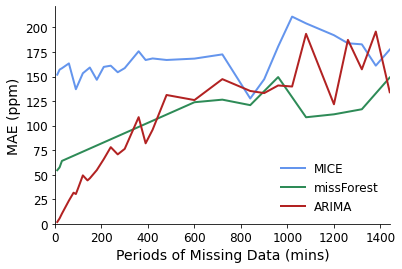

In [5]:
plot_mae(df,"co2",save=False)

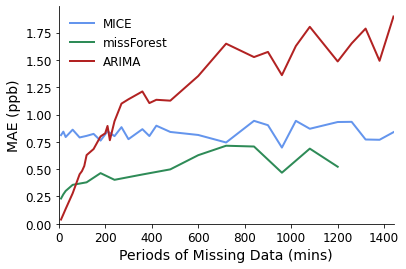

In [6]:
plot_mae(df,"co",save=False)

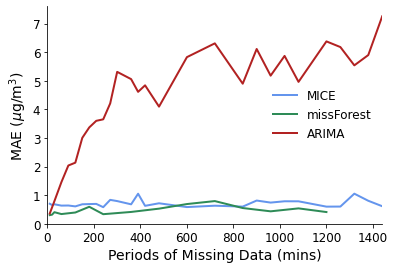

In [7]:
plot_mae(df,"pm2p5_mass",save=False)

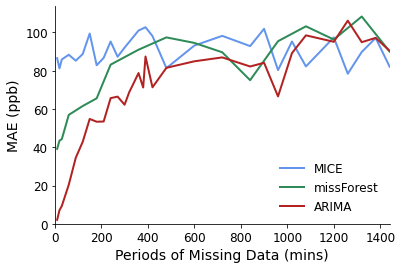

In [8]:
plot_mae(df,"tvoc",save=False)

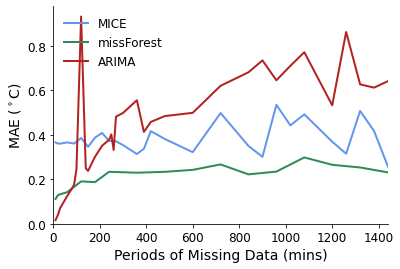

In [9]:
plot_mae(df,"temperature_c",save=True)

In [53]:
df[(df["Param"] == "temperature_c") & (df["Model"] == "ARIMA")].sort_values("Period")

,Param,Model,Period,Pearson Correlation,MAE,RMSE,Index of Agreement
320,temperature_c,ARIMA,10,0.998486,0.016609,0.036285,0.999621
9,temperature_c,ARIMA,20,0.991800,0.039533,0.080939,0.997938
96,temperature_c,ARIMA,30,0.978437,0.070851,0.131203,0.994620
24,temperature_c,ARIMA,60,0.948113,0.124532,0.208962,0.986475
43,temperature_c,ARIMA,80,0.917761,0.157348,0.266218,0.977774
150,temperature_c,ARIMA,90,0.900026,0.176877,0.295271,0.973002
53,temperature_c,ARIMA,100,0.692184,0.245151,0.436610,0.931792
70,temperature_c,ARIMA,120,-10.992841,0.932268,1.827184,0.810741
78,temperature_c,ARIMA,140,0.822795,0.249918,0.384068,0.947492
162,temperature_c,ARIMA,150,0.835704,0.238152,0.358419,0.952034
